In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv

## Gaussian Process Regression

#### scikit-learn의 Gaussian Process Regression 패키지 활용
- Gaussian Process 를 위해 GaussianProcessRegressor 모듈 import 
- 그리고 Kernel 구성을 위해 커널 모듈을 import 함

In [2]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

plot을 그리기 위한 함수 정의 

In [3]:
def plot_gp(mu, cov, X, X_train=None, Y_train=None, samples=[]):
    X = X.ravel()
    mu = mu.ravel()
    uncertainty = 1.96 * np.sqrt(np.diag(cov))
    
    plt.fill_between(X, mu + uncertainty, mu - uncertainty, alpha=0.1)
    plt.plot(X, mu, label='Mean')
    for i, sample in enumerate(samples):
        plt.plot(X, sample, lw=1, ls='--', label=f'Sample {i+1}')
    if X_train is not None:
        plt.plot(X_train, Y_train, 'rx')
    plt.legend()

- noise $\epsilon$ 값 설정
- 훈련 데이터(x_tr, y_tr) 데이터 생성

In [4]:
noise = 0.4
x_tr = np.arange(-2,1,0.2).reshape(-1,1)
y_tr = np.sin(x_tr) + noise*np.random.randn(*x_tr.shape)

- GP 모델 적용을 위해서는 prior에 대한 정의가 필요
- Prior의 평균을 0으로 설정하려면, GaussianProcessRegressor() 함수 안의 normalize_y = False 옵션(default)
- alpha는 아래 수식에서의 $\beta$ 에 해당

$p(t_{n+1}\vert t_{1},...,t_{n}) \sim \mathcal{N}\left(\mu(t_{n+1}),\sigma^{2}(t_{n+1}\right)$ \<br>

$\mu(t_{n+1}) = \mathbf{k}^{T}\text{Cov}_{n}^{-1}\mathbf{t}_{n}$ \<br>

$\sigma^{2}(t_{n+1}) = k_{(n+1)(n+1)}+\beta - \mathbf{k}^{T}\text{Cov}_{n}^{-1}\mathbf{k}$

In [5]:
ker = ConstantKernel(1.0)*RBF(length_scale = 1.0)
gpr = GaussianProcessRegressor(kernel = ker, alpha = noise**2)

- fit 함수를 이용해서 Gaussian Process Regression 모델 적합

In [6]:
gpr.fit(x_tr, y_tr)

GaussianProcessRegressor(alpha=0.16000000000000003,
                         kernel=1**2 * RBF(length_scale=1))

- 예측하고 싶은 새로운 데이터를 생성
- 새로운 값이 존재하는 범위에서의 함수의 분포를 알아보고자 한다.
- 기존 훈련 데이터 값이 있었던 범위라면, 그곳에서 추정하는 함수의 변동성은 작을 것이다
- 기존 훈련 데이터 값이 없었던 범위라면, 해당 범위에서의 추정하는 함수의 변동성은 클 것

In [7]:
y = np.arange(-3, 3, 0.2).reshape(-1,1)

- Gaussain Porcess Regression을 통한 예측
- 예측하고자 하는 포인트에 대해서 넣어주고, joint predictive distribution의 covariance 부분을 받기 위해서 옵션을 True로 설정해준다

In [8]:
mu_s, cov_s = gpr.predict(y, return_cov = True)

In [9]:
sigma_f_opt = np.sqrt(gpr.kernel_.k1.get_params()['constant_value'])
l_opt = gpr.kernel_.k2.get_params()['length_scale']

print("optimal kernel parameter of l : {:.3f}".format(l_opt))
print("optimal kernel parameter of sigma_f : {:.3f}".format(sigma_f_opt))

optimal kernel parameter of l : 0.978
optimal kernel parameter of sigma_f : 0.670


plot을 그려본 결과, 관측 데이터 포인트가 있어 학습이 이루어진 곳에서 함수 추정 불확실성이 줄어든 것을 확인할 수 있다. 

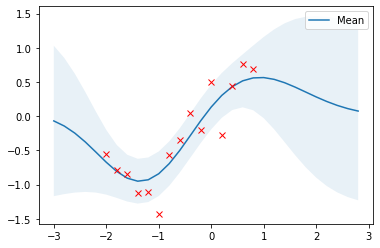

In [10]:
plot_gp(mu_s, cov_s, y, X_train = x_tr, Y_train = y_tr)

학습시키는 훈련 데이터를 증가하면, 훈련 데이터가 있는 범위에서의 불확실성은 더욱 줄어든다.

In [11]:
noise = 0.4
x_tr = np.arange(-2,3,0.1).reshape(-1,1)
y_tr = np.sin(x_tr) + noise*np.random.randn(*x_tr.shape)

In [12]:
ker = ConstantKernel(1.0)*RBF(length_scale = 1.0)
gpr = GaussianProcessRegressor(kernel = ker, alpha = noise**2)
gpr.fit(x_tr, y_tr)

GaussianProcessRegressor(alpha=0.16000000000000003,
                         kernel=1**2 * RBF(length_scale=1))

In [13]:
mu_s, cov_s = gpr.predict(y, return_cov = True)

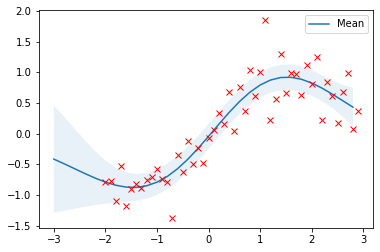

In [14]:
plot_gp(mu_s, cov_s, y, X_train = x_tr, Y_train = y_tr)

## Gaussian Process Classifier

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import bernoulli
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

### 1D data example
- data set generate
- sin함수에 입력한 결과를 sigmoid 함수를 취해 bernoulli 분포 기반 $t \in \{0,1\}$ 결정

In [2]:
np.random.seed(50120057)

x = np.arange(0,5,0.2).reshape(-1,1)
x_ts = np.arange(-2,7,0.1).reshape(-1,1)

a = 2*np.sin(x*np.pi*0.5)
t = bernoulli.rvs(1/(1+np.exp(-a)))

In [3]:
def plot_data_1D(X,t) :
    class_0 = t == 0
    class_1 = t == 1
    
    plt.scatter(X[class_1], t[class_1], label = 'Class 1', marker = 'x', color= 'red')
    plt.scatter(X[class_0], t[class_0], label = 'Class 0', marker = 'o', edgecolors= 'blue', facecolors = 'none')

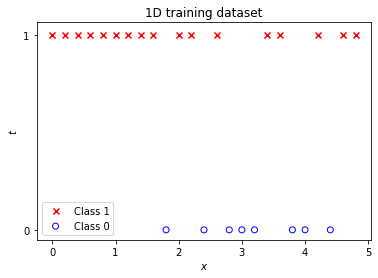

In [4]:
plot_data_1D(x,t)
plt.title('1D training dataset')
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.yticks([0,1])
plt.legend()

- Gaussian Process Classifier 모델 적합
- Kernel 설정 및 hyperparameter에 대한 초기값 부여를 각 1.0으로 설정
- 모델 fit한 결과 각 hyperparameter에 대한 optimized된 결과는 1.35와 1.64

In [5]:
rbf = ConstantKernel(1.0)*RBF(length_scale = 1.0)
gpc = GaussianProcessClassifier(kernel = rbf)

gpc.fit(x, t.ravel())

GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))

In [6]:
theta0 = gpc.kernel_.k2.get_params()['length_scale']
theta1 = np.sqrt(gpc.kernel_.k1.get_params()['constant_value'])

In [7]:
print(f'Optimized theta = [{theta0:.3f},{theta1:.3f}], negative log likelihood = {-gpc.log_marginal_likelihood_value_:.3f}')

Optimized theta = [1.351,1.644], negative log likelihood = 15.737


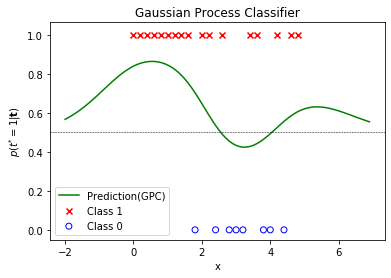

In [8]:
pt_test_gpc = gpc.predict_proba(x_ts.reshape(-1,1))[:,-1]

plot_data_1D(x,t)
plt.plot(x_ts, pt_test_gpc, label = 'Prediction(GPC)', color = 'green')
plt.axhline(0.5, x_ts.min(), x_ts.max(), color = 'black', ls = '--', lw = 0.5)
plt.title('Gaussian Process Classifier')
plt.xlabel('x')
plt.ylabel('$p(t^{*}=1|\mathbf{t})$')
plt.legend()

### 2D data example
- scikit learn의 make_moons 모듈을 이용한 예제 생성
- 아래의 과정은 1D data example에서 실행한 것과 동일

In [9]:
from sklearn.datasets import make_moons

In [10]:
def plot_data_2D(x,t) :
    class_1 = np.ravel(t == 1)
    class_0 = np.ravel(t == 0)
    
    plt.scatter(x[class_1,0], x[class_1,1], label = 'Class 1', marker = 'x', c = 'red')
    plt.scatter(x[class_0,0], x[class_0,1], label = 'Class 0', marker = 'o', edgecolors = 'blue', facecolors = 'none')
    
    plt.xlabel('$x_{1}$')
    plt.ylabel('$x_{2}$')

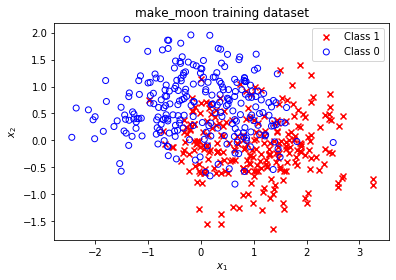

In [11]:
x,t = make_moons(500, noise =0.5, random_state = 50120057)
t = t.reshape(-1,1)

plot_data_2D(x,t)
plt.title('make_moon training dataset')
plt.legend()

In [12]:
rbf = ConstantKernel(1.0)*RBF(length_scale = 1.0)
gpc = GaussianProcessClassifier(kernel = rbf)

gpc.fit(x, t.ravel())

GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))

In [13]:
theta0 = gpc.kernel_.k2.get_params()['length_scale']
theta1 = np.sqrt(gpc.kernel_.k1.get_params()['constant_value'])

In [14]:
print(f'Optimized theta = [{theta0:.3f},{theta1:.3f}], negative log likelihood = {-gpc.log_marginal_likelihood_value_:.3f}')

Optimized theta = [1.120,3.945], negative log likelihood = 209.817


In [15]:
def plot_pt_2D(grid_x, grid_y, grid_z) :
    plt.contourf(grid_x, grid_y, grid_z, cmap = 'plasma', alpha = 0.3, levels = np.linspace(0,1,11))
    plt.colorbar(format='%.2f')

In [16]:
def plot_db_2D(grid_x, grid_y, grid_z, decision_boundary =0.5):
    levels = [decision_boundary]
    cs = plt.contour(grid_x, grid_y, grid_z, levels = levels, colors = 'black'
                    , linestyles = 'dashed', linewidths = 2)
    plt.clabel(cs, fontsize =20)

In [17]:
grid_x, grid_y = np.mgrid[-4:4:200j, -4:4:200j]
grid = np.stack([grid_x,grid_y], axis = -1)

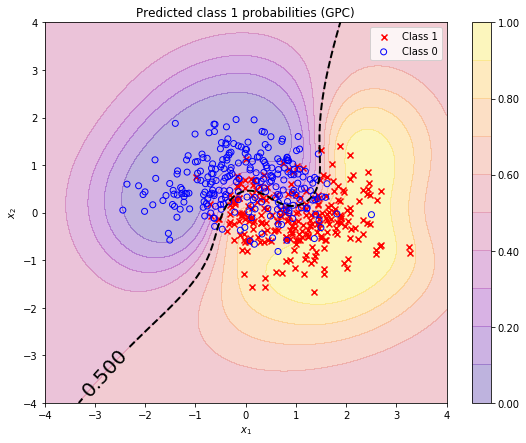

In [18]:
pt_test_gpc = gpc.predict_proba(grid.reshape(-1,2))[:,1].reshape(*grid_x.shape)

plt.figure(figsize=(9,7))
plot_pt_2D(grid_x, grid_y, pt_test_gpc)
plot_db_2D(grid_x, grid_y, pt_test_gpc, decision_boundary = 0.5)
plot_data_2D(x,t)
plt.title('Predicted class 1 probabilities (GPC)')
plt.legend()